# =========================================================
# PolyEpi: Polygenic Phenotype with Higher-Order Epistasis Interactios
# =========================================================

# Path to the config file (Modify this before running the notebook.

In [1]:
configFilePath='SampleData/config-1000Genomes-csv.json'

# Initialisation

In [2]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json

from pprint import pprint
from pdbio.vcfdataframe import VcfDataFrame

import itertools

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from scipy import stats
import sklearn

TA = [1, .5, 1e-1, 1e-2, 1e-3, 1e-8, 1e-20]

# Read the config file

In [3]:
with open(configFilePath, 'r') as f:
    config = json.load(f)

In [4]:
shuffleSnps = config['shuffleSnps']
inputType = config['inputType']
dumpCSV = config['dumpCSV']

vcfInputPath = config['inputPrefix']+'.vcf'
csvInputPath = config['inputPrefix']+'.csv'

outputPrefix = config['outputPrefix']

pvalueThr = config['pvalueThr']
numTree = config['numTree']
numLoop = config['numLoop']

# Compute total numebr of variables and number of requierd SNPs to form the variables

In [5]:
numVariables = 0
numSnpsNeeded = 0
maxOrder = 0

for v in config['variables']:
    v['numSNPs'] = v['numVar'] * v['numSnpsInVar']
    numVariables += v['numVar']
    numSnpsNeeded += v['numSNPs']
    if v['numSnpsInVar']>maxOrder:
        maxOrder = v['numSnpsInVar']
    
config['numVariables'] = numVariables
config['numSnpsNeeded'] = numSnpsNeeded
config['maxOrder'] = maxOrder

# Print config data and write it in "outputPrefix.config.json"

In [6]:
print("========== Configuration >>>")
pprint(config)
print("============================")
with open(outputPrefix+'.config.json','w') as outfile:
    json.dump(config, outfile)

========== Configuration >>>
{'dumpCSV': True,
 'inputPrefix': '1000Genomes/all-snps-header',
 'inputType': 'csv',
 'maxOrder': 5,
 'numLoop': 1,
 'numSnpsNeeded': 53,
 'numTree': 500,
 'numVariables': 24,
 'outputPrefix': 'SampleData/input-1000G',
 'pvalueThr': 0.001,
 'shuffleSnps': True,
 'variables': [{'numSNPs': 10, 'numSnpsInVar': 1, 'numVar': 10},
               {'numSNPs': 10, 'numSnpsInVar': 2, 'numVar': 5},
               {'numSNPs': 15, 'numSnpsInVar': 3, 'numVar': 5},
               {'numSNPs': 8, 'numSnpsInVar': 4, 'numVar': 2},
               {'numSNPs': 10, 'numSnpsInVar': 5, 'numVar': 2}]}


# Parse input genotype data from a VCF or CSV file
## If read from VCF file, the SNP id is set to CHROM:POS:REF:ALT

In [7]:
if inputType=='vcf':
    print("read in vcf")
    vcfdf = VcfDataFrame(path=vcfInputPath)
    print("read Dataframe")
    df = vcfdf.df
    df['SNP'] = df['#CHROM'].astype(str) + ':' + df['POS'].astype(str) + ':' + df['REF'].astype(str) + ':' + df['ALT'].astype(str)
    df = df.set_index('SNP')
    snpData = df.iloc[:,9:].replace(['0/0','0/1','1/1'], [0,1,2])
    if dumpCSV:
        snpData.to_csv(csvInputPath)
elif inputType=='csv':
    print("read in csv")
    snpData = pd.read_csv(csvInputPath)
    snpData = snpData.set_index('SNP')
    #snpData = pd.read_csv(csvInputPath, header=None, index_col=0, skiprows=1)

else:
    print("Incorrect inputType (should be 'vcf' or 'csv')")
    exit()

read in csv


In [8]:
snpData.iloc[:5,:5]

,HG00096,HG00097,HG00099,HG00100,HG00101
SNP,,,,,
1:15820:G:T,1,1,1,0,0
1:62777:A:T,1,1,0,1,1
1:63268:T:C,0,0,0,0,1
1:843405:A:G,1,1,0,0,2
1:1012483:G:T,0,2,2,2,2


# There should be enough SNPs in the input file to create all variables

In [9]:
print("Number of SNPs in the input file: ", snpData.shape[0])
print("Number of SNPs needed: ", numSnpsNeeded)

if snpData.shape[0] < numSnpsNeeded:
    print("There are not enough SNPs in the input file")
    exit(1)
else:
    print("There are enough SNPs in the input file")

Number of SNPs in the input file:  17373
Number of SNPs needed:  53
There are enough SNPs in the input file


# Suffle SNPs if asked in the config file.
## When SNPs are shuffled different set of SNPs used to form each variables each time

In [10]:
if shuffleSnps:
    snpData = snpData.sample(frac=1)

# Transpose the genotype data and print number of snps and samples
## Also rename 0/0, 0/1 and 1/1 to R, H and A

In [11]:
snpData = snpData.T

In [12]:
df = snpData.replace([0,1,2],['R','H','A'])
numSampels = df.shape[0]
numSNPs = df.shape[1]
print("number of sample",numSampels)
print("number of snp",numSNPs)

number of sample 2504
number of snp 17373


In [13]:
df.iloc[:5,:5]

SNP,9:129284289:T:C,19:56368427:C:T,21:39833569:T:C,17:7978751:G:A,13:37445398:T:A
HG00096,R,R,H,R,H
HG00097,H,H,H,A,R
HG00099,R,H,A,R,H
HG00100,R,A,A,R,R
HG00101,R,R,H,H,R


# Form variables from SNPs
## A variable could be a SNPs or a set of Interactive SNPs
## First identify whcih SNPs belong to each variable and then form the variables
## Naming of variables: O3V4 is the 4th variable with 3-interactive SNPs
## Write Variables SNPs infor in "outputPrefix.varData.csv"

In [14]:
colNames = list() # to store variable names
for o,v in enumerate(config['variables']):
    for i in range(0,v['numVar']):
        colNames.append('O'+str(o+1)+'V'+str(i+1))

In [15]:
rowNames = ['order']
for o in range(maxOrder):
    rowNames.append('snp_'+str(o+1))

In [16]:
varData = pd.DataFrame(index=rowNames, columns=colNames)

In [17]:
idx = 0
for o,v in enumerate(config['variables']):
    for i in range(0,v['numVar']):
        name = 'O'+str(o+1)+'V'+str(i+1)
        varData.at['order',name] = str(o+1)
        for k in range(0,v['numSnpsInVar']):
            snp = 'snp_'+str(k+1)
            varData.at[snp,name]=df.columns[idx]
            idx += 1
varData = varData.fillna('---')

In [18]:
varData.to_csv(outputPrefix+'.varData.csv')

In [19]:
varData.iloc[:6,-5:]

,O3V5,O4V1,O4V2,O5V1,O5V2
order,3,4,4,5,5
snp_1,18:511960:C:T,10:122802506:G:A,20:603259:C:A,9:29938824:A:G,18:72871756:A:G
snp_2,21:42495445:C:A,18:13177130:C:A,3:45152557:G:A,20:17417133:T:G,8:38318337:G:C
snp_3,10:92006017:G:A,5:157520711:T:C,17:78235300:A:G,1:11661209:A:G,6:86973749:C:T
snp_4,---,16:86391306:C:T,4:57569547:T:C,3:29181801:G:A,4:88068837:G:A
snp_5,---,---,---,13:107092680:G:A,6:3073377:C:T


# Form Variable Genotype and write it to "outputPrefix.varGT.csv"
## For variables with more than one SNPs the genotype is the concatination of all SNPs involved
## For example RHA, ARH and AAR could be genotype value of a variable with 3 snps

In [20]:
varGT = df.iloc[:,-1:0].copy()

In [21]:
for o,v in enumerate(config['variables']):
    for i in range(0,v['numVar']):
        name = 'O'+str(o+1)+'V'+str(i+1)
        varGT[name] = ''
        for k in range(0,v['numSnpsInVar']):
            snp = 'snp_'+str(k+1)
            varGT[name] = varGT[name] + df[varData.loc[snp,name]]

In [22]:
varGT.to_csv(outputPrefix+'.varGT.csv')

In [23]:
varGT.iloc[:5,-5:]

SNP,O3V5,O4V1,O4V2,O5V1,O5V2
HG00096,RAH,RHRR,AHHA,RAARH,RAHHR
HG00097,RRA,RHRH,HHAR,HRAHR,HAHRH
HG00099,RHA,RARH,RHRR,HRHRH,RHRRH
HG00100,RRH,RHHA,HRHA,HHARR,HAHRH
HG00101,RAH,HHHR,RHHH,RHARR,HAARR


# This function compute Risks based on given phenotype

In [24]:
def FindRisks(df):
    varNames = df.columns[0:-1]
    
    case, ctrl = df[df['lbl']==1], df[df['lbl']==0]
    
    GS = dict()
    
    for i,v in enumerate(varNames):

        caseC=case[v].value_counts()
        ctrlC=ctrl[v].value_counts()

        count = caseC.to_frame().join(ctrlC.to_frame(),lsuffix='_case', rsuffix='_ctrl',how='outer').fillna(0)
        #count = count.iloc[:,:-1]
        count.columns = ['case', 'ctrl']
        count['p'] = (count['case']+1)/(count['ctrl']+1)
        #count['p'] /= count['p'].sum()
        
        GS[v] = count
    return GS

# This function update phenotype based on given Risks

In [25]:
def Predict(df,GS):
    df['prob'] = 0.0;
    for sample in df.index:
        prob = 0.0
        for var in df.drop(['lbl','prob'], axis=1).columns:
            G = GS[var]
            g = df.loc[sample,var]
            if g in G.index:
                prob += G.loc[g,'p']
        df.at[sample,'prob'] = prob

    mid = df['prob'].mean()
    df['lbl'] = df['prob'].apply(lambda x: 1 if(x>mid) else 0)

# Assign random phenotype to samples
# 0 for control and 1 for case

In [26]:
varGT['lbl'] = np.random.randint(0, 2, varGT.shape[0])

In [27]:
varGT[['lbl']].head(5)

SNP,lbl
HG00096,0
HG00097,1
HG00099,0
HG00100,1
HG00101,1


# Compute and plot chi2-pvalue (log10) of the variables for the random phenotype

,number of SNPs exceed the p-value
p-value,
1.000000e+00,24
5.000000e-01,8
1.000000e-01,1
1.000000e-02,0
1.000000e-03,0
1.000000e-08,0
1.000000e-20,0


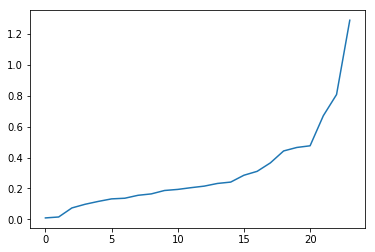

In [28]:
features = varGT.columns[:-1]
corrDict = dict()
for v in features:
    corrDict[v] = stats.chi2_contingency(pd.crosstab(varGT['lbl'],varGT[v]).values)[1]
a = np.asarray(list(corrDict.values()))
b = - np.log10(a)
plt.plot(np.sort(b))
nsat = list()
for t in TA:
    nsat.append([t, np.where(a<t)[0].shape[0]])
x = pd.DataFrame(nsat)
x.columns =['p-value', 'number of SNPs exceed the p-value']
x.set_index('p-value')

# >>>> Phenotype Simulation Feedback loop <<<<

In [29]:
for i in range(numLoop):
    print('loop', i+1)
    Risks = FindRisks(varGT)
    Predict(varGT,Risks)
    varGT = varGT.drop(['prob'], axis=1)
print("Done")

loop 1
Done


# Write Phenotype into a file outputPrefix.pheno.csv

In [30]:
phen = varGT[['lbl']].copy()
phen.index.name ='sample'
phen.to_csv(outputPrefix+'.pheno.csv')

In [31]:
phen.head()

SNP,lbl
sample,
HG00096,0
HG00097,1
HG00099,0
HG00100,1
HG00101,1


# Compute and plot chi2-pvalue (log10) of the variables for the simulated phenotype

,number of SNPs exceed the p-value
p-value,
1.000000e+00,24
5.000000e-01,22
1.000000e-01,17
1.000000e-02,14
1.000000e-03,14
1.000000e-08,8
1.000000e-20,2


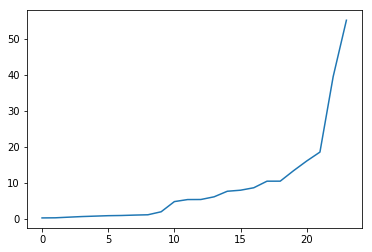

In [32]:
features = varGT.columns[:-1]
corrDict = dict()
for v in features:
    corrDict[v] = stats.chi2_contingency(pd.crosstab(varGT['lbl'],varGT[v]).values)[1]
a = np.asarray(list(corrDict.values()))
b = - np.log10(a)
plt.plot(np.sort(b))
nsat = list()
for t in TA:
    nsat.append([t, np.where(a<t)[0].shape[0]])
x = pd.DataFrame(nsat)
x.columns =['p-value', 'number of SNPs exceed the p-value']
x.set_index('p-value')

# Filter Variable that satisfy p-value treshold as Truth Variable and write it to "outputPrefix.varDataTruth.csv"

In [33]:
variables = list()
for v in corrDict:
    if corrDict[v]<pvalueThr:
        variables.append(v)

varDataTruth = varData[variables]
varDataTruth.to_csv(outputPrefix+'.varDataTruth.csv')

In [34]:
print("Number of Variables: ",varData.shape[1])
print("Number of Truth Variables: ",varDataTruth.shape[1])

Number of Variables:  24
Number of Truth Variables:  14


In [35]:
varDataTruth.iloc[:6,-5:]

,O3V5,O4V1,O4V2,O5V1,O5V2
order,3,4,4,5,5
snp_1,18:511960:C:T,10:122802506:G:A,20:603259:C:A,9:29938824:A:G,18:72871756:A:G
snp_2,21:42495445:C:A,18:13177130:C:A,3:45152557:G:A,20:17417133:T:G,8:38318337:G:C
snp_3,10:92006017:G:A,5:157520711:T:C,17:78235300:A:G,1:11661209:A:G,6:86973749:C:T
snp_4,---,16:86391306:C:T,4:57569547:T:C,3:29181801:G:A,4:88068837:G:A
snp_5,---,---,---,13:107092680:G:A,6:3073377:C:T


# Filter SNPs included in All and Truth Variables
## write the Truth SNP names in  "outputPrefix.TruthSNP.csv"

In [36]:
snps = np.unique(varDataTruth.replace(np.nan, '', regex=True).drop('order').values.ravel())[1:]
snpDataTruth = snpData.loc[:, snpData.columns.isin(snps)]

snps2 = np.unique(varData.replace(np.nan, '', regex=True).drop('order').values.ravel())[1:]
snpDataVar = snpData.loc[:, snpData.columns.isin(snps2)]

pd.DataFrame(snps).rename(columns={0:'v'}).to_csv(outputPrefix+'.TruthSNP.csv',index=False)

In [37]:
print("Number of SNPs used to form Variables: ",snpDataVar.shape[1])
print("Number of Truth SNPs (SNPs in Truth Variables): ",snpDataTruth.shape[1])

Number of SNPs used to form Variables:  53
Number of Truth SNPs (SNPs in Truth Variables):  42


In [38]:
snpDataTruth.iloc[:5,-5:]

SNP,18:72871756:A:G,8:38318337:G:C,6:86973749:C:T,4:88068837:G:A,6:3073377:C:T
HG00096,0,2,1,1,0
HG00097,1,2,1,0,1
HG00099,0,1,0,0,1
HG00100,1,2,1,0,1
HG00101,1,2,2,0,0


# Add Phenotype to SNP Data

In [39]:
snpDataTruth['lbl'] = varGT['lbl']
snpDataVar['lbl'] = varGT['lbl']
snpData['lbl'] = varGT['lbl']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# This function used to predict lable using RandomForest
## 75% training and 25% test

In [40]:
def RF_AUC(dfx, nTree):
    df = dfx.copy()
    features = df.columns[:-1]
    
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
    train, test = df[df['is_train']==True], df[df['is_train']==False]
    clf = RandomForestClassifier(n_jobs=2, n_estimators=nTree, random_state=0)
    clf.fit(train[features], train['lbl'])
    #clf.predict(test[features])
    prob = clf.predict_proba(test[features])
    y_true = test['lbl']
    y_scores = prob[:,1]
    return clf, roc_auc_score(y_true, y_scores)


# Train and test RandomForest for TruthSNP as well as for all SNP in the input file
## Print AUC
## Plot Importance Score

In [41]:
clfTruth, AucTruth = RF_AUC(snpDataTruth, nTree=numTree)
clfVar,   AucVar   = RF_AUC(snpDataVar  , nTree=numTree)
clf,      Auc      = RF_AUC(snpData     , nTree=numTree)

In [42]:
print("AUC Truth SNPs            : ", AucTruth )
print("AUC All SNPs in Variables : ", AucVar )
print("AUC All SNPs in input file: ", Auc)

AUC Truth SNPs            :  0.677664550618109
AUC All SNPs in Variables :  0.6479263849242267
AUC All SNPs in input file:  0.49854511609679636


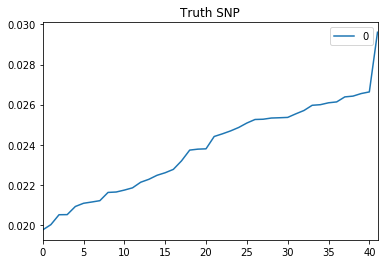

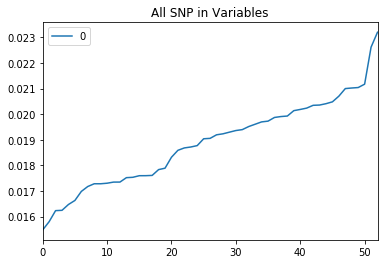

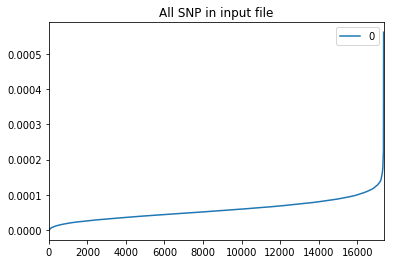

In [43]:
pd.DataFrame(np.sort(clfTruth.feature_importances_)).plot(title="Truth SNP")
pd.DataFrame(np.sort(clfVar.feature_importances_)).plot(title="All SNP in Variables")
pd.DataFrame(np.sort(clf.feature_importances_)).plot(title="All SNP in input file")

In [44]:
snpDataTruth

SNP,21:39833569:T:C,12:83588033:G:A,17:48029454:C:T,9:135966362:C:T,1:34247946:A:G,4:175528397:T:G,2:222415138:G:A,8:52930270:G:A,6:130935956:A:T,13:105633176:C:T,...,20:17417133:T:G,1:11661209:A:G,3:29181801:G:A,13:107092680:G:A,18:72871756:A:G,8:38318337:G:C,6:86973749:C:T,4:88068837:G:A,6:3073377:C:T,lbl
HG00096,1,1,1,1,1,2,0,0,0,2,...,2,2,0,1,0,2,1,1,0,0
HG00097,1,2,0,1,1,1,0,0,0,2,...,0,2,1,0,1,2,1,0,1,1
HG00099,2,1,0,2,1,2,0,0,1,2,...,0,1,0,1,0,1,0,0,1,0
HG00100,2,2,0,0,1,2,1,0,1,2,...,1,2,0,0,1,2,1,0,1,1
HG00101,1,1,0,1,0,2,2,0,0,1,...,1,2,0,0,1,2,2,0,0,1
HG00102,1,1,0,1,1,2,0,0,1,1,...,2,2,1,0,1,1,0,0,1,1
HG00103,2,2,0,1,1,2,0,0,0,1,...,1,2,0,0,1,1,0,0,0,1
HG00105,2,2,0,2,2,2,0,1,1,2,...,1,1,0,0,1,0,1,0,1,1
HG00106,2,1,0,0,0,2,0,0,0,1,...,2,1,1,0,1,2,1,0,0,1
HG00107,2,1,1,0,1,2,0,0,0,1,...,2,1,1,0,1,1,2,1,1,0
